In [49]:
import sys, os
import numpy as np
import h5py
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMakerCVAE import *

In [7]:
LATENT_DIM = 16
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 64, 64)
BATCH_SIZE = 4096
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-2

In [8]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 40511)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [9]:
args_gen = {'X_key' : 'image',
    'y_key' : 'specz_redshift',
    'scaler' : False,
    'labels_encoding' : False,
    'batch_size': BATCH_SIZE,
    'mode' : 'train',
    'shuffle' : False}

train_gen = HDF5ImageGenerator(src = '/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_training_z_less_than_2.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_testing_z_less_than_2.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/tuando/data/HSC/HSC_v6/step3A/64x64/5x64x64_validation_z_less_than_2.hdf5', **args_gen)

In [50]:
prior = tfd.Independent(tfd.Normal(loc = tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1, ))
x = Conv2D(32, 3, strides = 2, padding = 'same', data_format = 'channels_first')(images)
x = BatchNormalization(axis = 1)(x)
x = Activation("relu")(x)

x = Conv2D(64, 3, strides = 2, padding = 'same', data_format = 'channels_first')(x)
x = BatchNormalization(axis = 1)(x)
x = Activation("relu")(x)

x = Conv2D(128, 2, strides = 1, padding = 'same', data_format = 'channels_first')(x)
x = BatchNormalization(axis = 1)(x)
x = Activation("relu")(x)

x = Conv2D(256, 2, strides = 1, padding = 'same', data_format = 'channels_first')(x)
x = BatchNormalization(axis = 1)(x)
x = Activation("relu")(x)

x = Flatten()(x)
x = Concatenate()([x, redshifts])

x = Dense(1024, activation = "relu")(x)
x = Dense(1024, activation = "relu")(x)

x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight = 1.0))(x)

encoder = Model([images, redshifts], z)

In [51]:
zc = Input(shape = (LATENT_DIM + 1,))
x = Dense(1024)(zc)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(256 * 16 * 16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Reshape((256, 16, 16))(x)
x = Conv2DTranspose(128, 2, strides = 1, padding = 'same', data_format = 'channels_first')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(64, 2, strides = 1, padding = 'same', data_format = 'channels_first')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(32, 3, strides = 2, padding = 'same', data_format = 'channels_first')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(5, 3, strides = 2, padding = 'same', data_format = 'channels_first')(x)
outputs = Reshape(IMAGE_SHAPE)(x)
decoder = Model(zc, outputs)

In [52]:
z = encoder([images, redshifts])
zc = Concatenate()([z, redshifts])
decoder_output = decoder(zc)

model = Model(inputs = [images, redshifts], outputs = decoder_output)

In [53]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 64, 64)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 32)   1472        ['input_9[0][0]']                
                                                                                                  
 batch_normalization_19 (BatchN  (None, 32, 32, 32)  128         ['conv2d_13[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 32)   0           ['batch_normalization_19[0]

In [54]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')

In [55]:
run = neptune.init_run(
    name = "CVAE",
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

model_name = 'cvae_rockfish'

weights_path = os.path.join('/data/tuando/models/', model_name) + '/weights'

neptune_callback = NeptuneCallback(run = run)

LR_callback = ReduceLROnPlateau()

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-199


In [ ]:
history = model.fit(train_gen, epochs = 100, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

Epoch 1/100
44/44 [==============================] - 46s 997ms/step - loss: 157.1275 - val_loss: 12.6124 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - 39s 881ms/step - loss: 7.7350 - val_loss: 10.4620 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - 39s 890ms/step - loss: 6.6869 - val_loss: 8.3055 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - 40s 905ms/step - loss: 5.9824 - val_loss: 7.3605 - lr: 0.0010
Epoch 5/100
44/44 [==============================] - 40s 899ms/step - loss: 5.3898 - val_loss: 5.5968 - lr: 0.0010
Epoch 6/100
44/44 [==============================] - 39s 886ms/step - loss: 5.1095 - val_loss: 5.3830 - lr: 0.0010
Epoch 7/100
44/44 [==============================] - 39s 888ms/step - loss: 4.9067 - val_loss: 4.4442 - lr: 0.0010
Epoch 8/100
44/44 [==============================] - 39s 886ms/step - loss: 4.7904 - val_loss: 5.0728 - lr: 0.0010
Epoch 9/100
44/44 [==============================] - 39s 887ms/step - loss: 

In [17]:
model.save_weights(weights_path)

In [18]:
model.load_weights(weights_path)

z = 0.0759000033


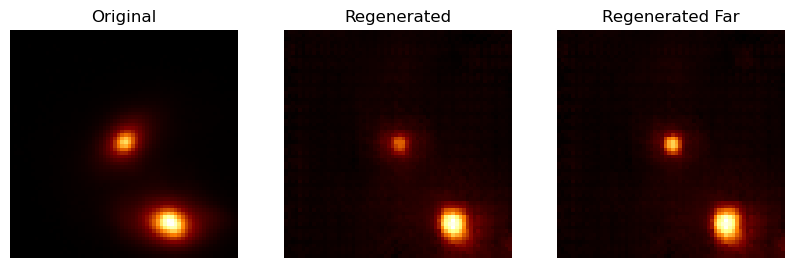

In [44]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 2
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

z = 0.123109996


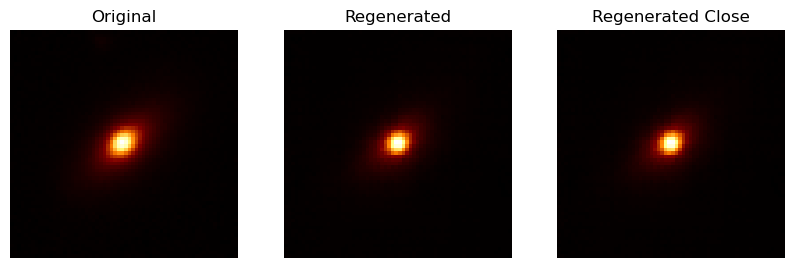

In [46]:
lib = 5
index = 273
z = test_gen[lib][0][1][index]
z_shifted = 0.1
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Close")
plt.show()

In [ ]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([2])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

In [ ]:
def scatter_bands_max_near_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.transpose(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][60:67]))[60:67].flatten()))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Maximum normalized pixel value z = {np.array([test_gen[0][0][1][i]])[0]}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]])))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([test_gen[0][0][0][i][j]])[0][63][63])
            pred_array = np.append(pred_array, model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][63][63])
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Central pixel value z = {np.array([test_gen[0][0][1][i]])}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.array([test_gen[lib][0][0][i][j]])[0][63][63])
        pred_array = np.append(pred_array, model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j][63][63])
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()
    
def scatter_bands_max_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.amax(np.array([test_gen[lib][0][0][i][j]])))
        pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j]])))
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show /  5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([test_gen[0][0][0][i][j]]).flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_mean = np.mean(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_arr = sorted(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_arr = true_arr[0 : int(len(true_arr) * .99)]
            pred_arr = pred_arr[0 : int(len(pred_arr) * .99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha = 0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha = 0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    loss = round(model.evaluate([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])], np.array([test_gen[0][0][0][index]]), verbose = 0), 2)
    for i in range(0, 5):
        axes[0][i].imshow(np.array([test_gen[0][0][0][index]])[0][i], cmap = 'afmhot')
        max_pixel_true = round(np.amax(np.array([test_gen[0][0][0][index]])[0][i]), 2)
        # axes[0][i].set_title(f'True band {i} max = {max_pixel_true}')
        pred = model([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])])[0][i]
        axes[1][i].imshow(pred, cmap = 'afmhot')
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'\n loss = {loss}') # f'Pred band {i} max = {max_pixel_pred}' + 
        
def display_high_loss(num_to_show, min_loss):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 5 * num_to_show))
    r = 0
    for i in range(BATCH_SIZE):
        loss = round(model.evaluate([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])], np.array([test_gen[0][0][0][i]]), verbose = 0), 2)
        if loss >= min_loss:
            print(i)
            for j in range(0, 5):
                axes[r][j].imshow(np.array([test_gen[0][0][0][i]])[0][j], cmap = 'afmhot')
                axes[r][j].set_title(f'Loss = {loss}')
            r += 1
        if r >= num_to_show:
            break

In [ ]:
hf = h5py.File('/data/tuando/data/CVAE/CVAE_v1/step1/64x64/5x64x64_cvae_generated_2.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(1999)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
# END